In [2]:
from fastai.imports import*
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

In [33]:
dataset = pd.read_csv("DatasetCompletoDiario.csv",sep=";");
dataset.columns = ['Data','PrecoDolar','QtdVendas','VolVarejo','FaturamentoIndust','IndsBebida','IndsMaquina','IndsMetal','IndsTextil','IndsTransf','IndsAlimen']
dataset['Data']= pd.to_datetime(dataset['Data'],format='%Y/%m/%d')

dataset['PrecoDolar'] = pd.to_numeric(dataset.PrecoDolar)
dataset['QtdVendas'] = pd.to_numeric(dataset.QtdVendas)
dataset['VolVarejo'] = pd.to_numeric(dataset.VolVarejo)
dataset['FaturamentoIndust'] = pd.to_numeric(dataset.FaturamentoIndust)
dataset['IndsBebida'] = pd.to_numeric(dataset.IndsBebida)
dataset['IndsMaquina'] = pd.to_numeric(dataset.IndsMaquina)
dataset['IndsMetal'] = pd.to_numeric(dataset.IndsMetal)
dataset['IndsTextil'] = pd.to_numeric(dataset.IndsTextil)
dataset['IndsTransf'] = pd.to_numeric(dataset.IndsTransf)
dataset['IndsAlimen'] = pd.to_numeric(dataset.IndsAlimen)


dataset= dataset.sort_values(['Data'])


In [34]:
# CRIANDO  DATAFRAME

range = dataset.Data
df=pd.DataFrame(index = dataset.Data)

dataset['PrecoDolar'].reset_index(drop=True, inplace=True)
dataset['QtdVendas'].reset_index(drop=True, inplace=True)
dataset['VolVarejo'].reset_index(drop=True, inplace=True)
dataset['FaturamentoIndust'].reset_index(drop=True, inplace=True)
dataset['IndsBebida'].reset_index(drop=True, inplace=True)
dataset['IndsMaquina'].reset_index(drop=True, inplace=True)
dataset['IndsMetal'].reset_index(drop=True, inplace=True)
dataset['IndsTextil'].reset_index(drop=True, inplace=True)
dataset['IndsTransf'].reset_index(drop=True, inplace=True)
dataset['IndsAlimen'].reset_index(drop=True, inplace=True)

df['PrecoDolar'] = dataset['PrecoDolar'].values
df['QtdVendas'] = dataset['QtdVendas'].values
df['VolVarejo'] = dataset['VolVarejo'].values
df['FaturamentoIndust'] = dataset['FaturamentoIndust'].values
df['IndsBebida'] = dataset['IndsBebida'].values
df['IndsMaquina'] = dataset['IndsMaquina'].values
df['IndsMetal'] = dataset['IndsMetal'].values
df['IndsTextil'] = dataset['IndsTextil'].values
df['IndsTransf'] = dataset['IndsTransf'].values
df['IndsAlimen'] = dataset['IndsAlimen'].values
###################### Features com lag que mais influenciavel  #################################

df['LAG 30 IndsMetal'] = dataset['IndsMetal'].values
df['LAG 30 PrecoDolar'] = dataset['PrecoDolar'].values
df['LAG 60 PrecoDolar'] = dataset['PrecoDolar'].values
df['LAG 60 VolVarejo'] = dataset['VolVarejo'].values




In [35]:
############## Aplicando o Lag

df['LAG 30 IndsMetal'] = df['IndsMetal'].shift(30, axis=0)
df['LAG 30 PrecoDolar'] = df['PrecoDolar'].shift(30, axis=0)
df['LAG 60 PrecoDolar'] = df['PrecoDolar'].shift(60, axis=0)
df['LAG 60 VolVarejo'] = df['VolVarejo'].shift(60, axis=0)


################## Substindo os NAN por ZERO #########################
df['LAG 30 IndsMetal'].fillna(0, inplace=True)
df['LAG 30 PrecoDolar'].fillna(0, inplace=True)
df['LAG 60 PrecoDolar'].fillna(0, inplace=True)
df['LAG 60 VolVarejo'].fillna(0, inplace=True)

# RANDOM FOREST

In [36]:
df_semVenda, y, nas = proc_df(df, 'QtdVendas')

In [37]:
#FUNÇÃO REPARTIR O DATASET EM TRAIN E TEST
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

n_valid =  130                          #(20% do dataset para validação)
n_trn = len(df_semVenda)-n_valid
raw_train, raw_valid = split_vals(df,n_trn)
train_features, test_features = split_vals(df_semVenda, n_trn)   ### train_features, test_features
train_labels, test_labels = split_vals(y, n_trn)             ### train_labels, test_labels   ##test_features, test_labels

train_features.shape, test_labels.shape, test_features.shape

((1175, 13), (130,), (130, 13))

In [38]:
#treinamento todos lag30 +lag60indmaq

# {'bootstrap': True,
#  'max_depth': 90,
#  'max_features': 6,
#  'min_samples_leaf': 9,
#  'min_samples_split': 12,
#  'n_estimators': 10}

In [39]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 90, 100, 120, 130, 135, 150, 200],
    'max_features': [2,4,6,8,10,12,13],
    'min_samples_leaf': [3,6,9,12,15],
    'min_samples_split': [8,9, 10, 12, 14, 16],
    'n_estimators': [10,20,50,100,200,400,600,800,1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [40]:
# # Fit the grid search to the data
# grid_search.fit(train_features, train_labels)
# grid_search.best_params_

In [41]:
    def forecast_accuracy(predictions, test_labels):
        forecast = predictions
        actual = test_labels
        #mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
        #me = np.mean(forecast - actual)             # ME
        mae = np.mean(np.abs(forecast - actual))    # MAE
        #mpe = np.mean((forecast - actual)/actual)   # MPE
        rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        corr = np.corrcoef(forecast, actual)[0,1]   # corr
        #mins = np.amin(np.hstack([forecast[:,None], 
                                  #actual[:,None]]), axis=1)
        #maxs = np.amax(np.hstack([forecast[:,None], 
         #                         actual[:,None]]), axis=1)
        #minmax = 1 - np.mean(mins/maxs)             # minmax

        return(corr)

In [42]:
    #FUNÇÃO REPARTIR O DATASET EM TRAIN E TEST
    def split_vals(a,n):
        return a[:n].copy(), a[n:].copy()

## Automação

In [62]:
corr = 0
x = 405

while predOtimizada2.sum() > 3000 or predOtimizada2.sum() < 2980:
    dataset = pd.read_csv("C:\\Users\\Anthony\\Desktop\\dataset csv\\Diario\\DatasetCompletoDiario.csv",sep=";");
    dataset.columns = ['Data','PrecoDolar','QtdVendas','VolVarejo','FaturamentoIndust','IndsBebida','IndsMaquina','IndsMetal','IndsTextil','IndsTransf','IndsAlimen']
    dataset['Data']= pd.to_datetime(dataset['Data'],format='%Y/%m/%d')

    dataset['PrecoDolar'] = pd.to_numeric(dataset.PrecoDolar)
    dataset['QtdVendas'] = pd.to_numeric(dataset.QtdVendas)
    dataset['VolVarejo'] = pd.to_numeric(dataset.VolVarejo)
    dataset['FaturamentoIndust'] = pd.to_numeric(dataset.FaturamentoIndust)
    dataset['IndsBebida'] = pd.to_numeric(dataset.IndsBebida)
    dataset['IndsMaquina'] = pd.to_numeric(dataset.IndsMaquina)
    dataset['IndsMetal'] = pd.to_numeric(dataset.IndsMetal)
    dataset['IndsTextil'] = pd.to_numeric(dataset.IndsTextil)
    dataset['IndsTransf'] = pd.to_numeric(dataset.IndsTransf)
    dataset['IndsAlimen'] = pd.to_numeric(dataset.IndsAlimen)
    dataset= dataset.sort_values(['Data'])


    # _______________________________CRIANDO  DATAFRAME

    # CRIANDO  DATAFRAME

    range = dataset.Data
    df=pd.DataFrame(index = dataset.Data)

    dataset['PrecoDolar'].reset_index(drop=True, inplace=True)
    dataset['QtdVendas'].reset_index(drop=True, inplace=True)
    dataset['VolVarejo'].reset_index(drop=True, inplace=True)
    dataset['FaturamentoIndust'].reset_index(drop=True, inplace=True)
    dataset['IndsBebida'].reset_index(drop=True, inplace=True)
    dataset['IndsMaquina'].reset_index(drop=True, inplace=True)
    dataset['IndsMetal'].reset_index(drop=True, inplace=True)
    dataset['IndsTextil'].reset_index(drop=True, inplace=True)
    dataset['IndsTransf'].reset_index(drop=True, inplace=True)
    dataset['IndsAlimen'].reset_index(drop=True, inplace=True)

    df['PrecoDolar'] = dataset['PrecoDolar'].values
    df['QtdVendas'] = dataset['QtdVendas'].values
    df['VolVarejo'] = dataset['VolVarejo'].values
    df['FaturamentoIndust'] = dataset['FaturamentoIndust'].values
    df['IndsBebida'] = dataset['IndsBebida'].values
    df['IndsMaquina'] = dataset['IndsMaquina'].values
    df['IndsMetal'] = dataset['IndsMetal'].values
    df['IndsTextil'] = dataset['IndsTextil'].values
    df['IndsTransf'] = dataset['IndsTransf'].values
    df['IndsAlimen'] = dataset['IndsAlimen'].values
    ###################### Features com lag que mais influenciavel  #################################

    df['LAG 30 IndsMetal'] = dataset['IndsMetal'].values
    df['LAG 30 PrecoDolar'] = dataset['PrecoDolar'].values
    df['LAG 60 PrecoDolar'] = dataset['PrecoDolar'].values
    df['LAG 60 VolVarejo'] = dataset['VolVarejo'].values

    ###################### Features com lag que mais influenciavel  #################################

    df_semVenda, y, nas = proc_df(df, 'QtdVendas')

    n_valid =  130                          #(20% do dataset para validação)
    n_trn = len(df_semVenda)-n_valid
    raw_train, raw_valid = split_vals(df,n_trn)
    train_features, test_features = split_vals(df_semVenda, n_trn)   ### train_features, test_features
    train_labels, test_labels = split_vals(y, n_trn)             ### train_labels, test_labels   ##test_features, test_labels

      ################################  RANDOMFOREST


    GridSearch_model = RandomForestRegressor(random_state = x, n_estimators = 10,min_samples_split=14,min_samples_leaf=12, max_features=8,max_depth=100)
    GridSearch_model.fit(train_features,train_labels)
    predOtimizada2 = GridSearch_model.predict(test_features)
    
    x = x +1
    corr= abs(forecast_accuracy(predOtimizada2, test_labels))
    #print(corr,predOtimizada2.sum(), x  )  





In [58]:
x= 409
GridSearch_model = RandomForestRegressor(random_state = x, n_estimators = 10,min_samples_split=14,min_samples_leaf=12, max_features=8,max_depth=100)
GridSearch_model.fit(train_features,train_labels)
predOtimizada2 = GridSearch_model.predict(test_features)

In [63]:
predictions = GridSearch_model.predict(test_features)
predictions_series = pd.Series(predictions, index=df.index[1175:])
train_series = pd.Series(train_labels, index=df.index[:1175])
test_series = pd.Series(test_labels, index=df.index[1175:])

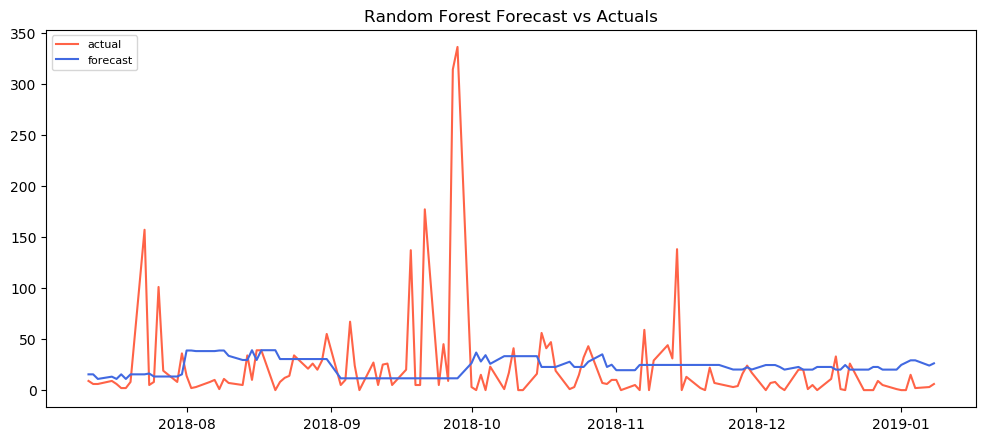

In [64]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='tomato')
plt.plot(predictions_series, label='forecast', color = 'royalblue')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Random Forest Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
import sys
def y(predictions, test_labels):
    forecast = predictions
    actual = test_labels
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mae': mae, 
            'rmse':rmse, 
            'corr':corr})

y(predOtimizada2, test_labels)

C:\Users\Anthony\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\Anthony\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


{'mae': 25.451408521684193,
 'rmse': 50.23290770222262,
 'corr': -0.24572847381541424}

In [66]:
#test_labels.sum()   ##3033
predOtimizada2.sum()  ##2982

2991.845548726345

In [67]:
x

409

In [69]:
fi = rf_feat_importance(GridSearch_model, df_semVenda)
fi[:19]

,cols,imp
10,LAG 30 PrecoDolar,0.233158
0,PrecoDolar,0.204988
11,LAG 60 PrecoDolar,0.197797
12,LAG 60 VolVarejo,0.058073
3,IndsBebida,0.053173
7,IndsTransf,0.042600
8,IndsAlimen,0.040979
6,IndsTextil,0.033959
5,IndsMetal,0.033383
2,FaturamentoIndust,0.029248


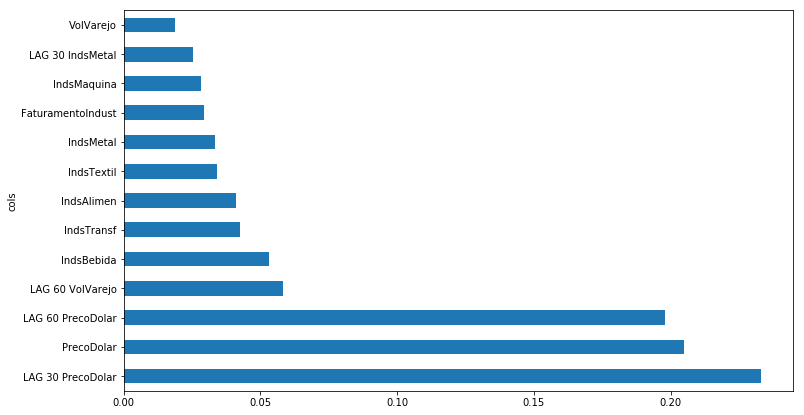

In [70]:
fi.imp.sum()
def plot_fi(fi):
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [48]:
import os

os.environ["PATH"] += os.pathsep + 'C:/Users/Anthony/Anaconda3/Library/bin/graphviz'
draw_tree(GridSearch_model.estimators_[10], df_semVenda, precision=3)

IndexError: list index out of range

In [53]:
random_state

NameError: name 'random_state' is not defined

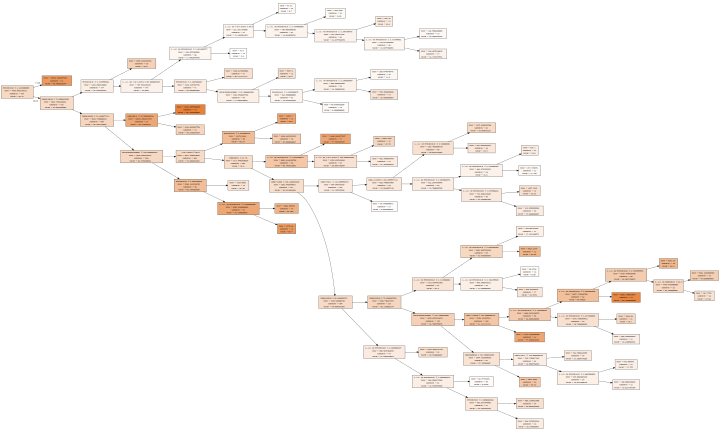

In [72]:
import os

os.environ["PATH"] += os.pathsep + 'C:/Users/Anthony/Anaconda3/Library/bin/graphviz'
draw_tree(GridSearch_model.estimators_[9], df_semVenda, precision=10)

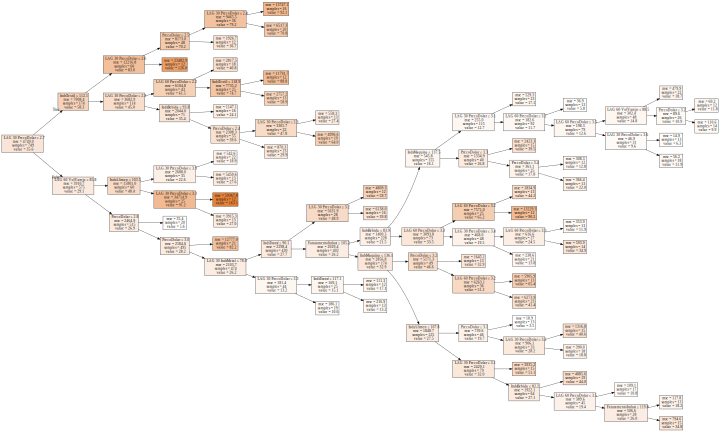

In [73]:
import os

os.environ["PATH"] += os.pathsep + 'C:/Users/Anthony/Anaconda3/Library/bin/graphviz'
draw_tree(GridSearch_model.estimators_[0], df_semVenda, precision=1)

In [74]:
#df.reset_index(level=0, inplace=True)
df['Data']= pd.to_datetime(df['Data'],format='%Y/%m/%d')
add_datepart(df,'Data')
df.head()

,PrecoDolar,QtdVendas,VolVarejo,FaturamentoIndust,IndsBebida,IndsMaquina,IndsMetal,IndsTextil,IndsTransf,IndsAlimen,...,DataDay,DataDayofweek,DataDayofyear,DataIs_month_end,DataIs_month_start,DataIs_quarter_end,DataIs_quarter_start,DataIs_year_end,DataIs_year_start,DataElapsed
0,2.3773,28,99.2,116.2,95.4,161.2,95.0,106.2,116.2,106.6,...,8,2,8,False,False,False,False,False,False,1389139200
1,2.3954,0,99.2,116.2,95.4,161.2,95.0,106.2,116.2,106.6,...,9,3,9,False,False,False,False,False,False,1389225600
2,2.3813,10,99.2,116.2,95.4,161.2,95.0,106.2,116.2,106.6,...,10,4,10,False,False,False,False,False,False,1389312000
3,2.3485,49,99.2,116.2,95.4,161.2,95.0,106.2,116.2,106.6,...,13,0,13,False,False,False,False,False,False,1389571200
4,2.3611,24,99.2,116.2,95.4,161.2,95.0,106.2,116.2,106.6,...,14,1,14,False,False,False,False,False,False,1389657600


In [77]:
from pdpbox import pdp
from plotnine import *

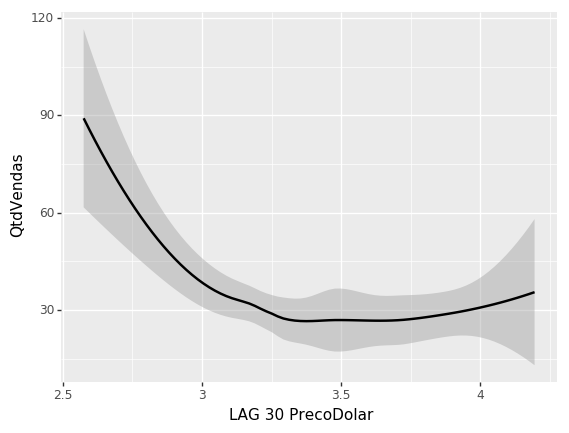

<ggplot: (131593737515)>

In [78]:
###           RELAÇÃO VENDAS X DOLAR

x_all = get_sample(df[df.DataYear>2014], 1300)
ggplot(x_all, aes('LAG 30 PrecoDolar','QtdVendas'))+stat_smooth(se=True, method='loess')